In [1]:
# Prepare the radar data and ECG data
import numpy as np
import datetime, time, copy, os, sys
import matplotlib.pyplot as plt
import neurokit2 as nk
from scipy.optimize import minimize,Bounds
import pandas as pd
# from utils import settings, load_bin, second_dev
from scipy.signal import hilbert, find_peaks, butter, sosfilt, sosfreqz
from sklearn.metrics import r2_score

In [2]:

def plot_template(a1, a2, b1, b2, c1, c2):
    fs = 200
    n = int(4*fs) # 4 sec
    dt = 1/fs
    t = np.linspace(0,n,n)*dt
    x1 = a1*np.exp(-((t-b1)**2)/(2*c1**2))
    x2 = a2*np.exp(-((t-b2)**2)/(2*c2**2))
    return x1+x2, int((b1-0.4)*fs), int((b2+0.7)*fs)
def moving_window_average(sig, win_len=3):
    if win_len % 2 == 0:
        win_len += 1
    sig = np.array(sig)
    sig = np.pad(sig, (win_len//2, win_len//2), mode='constant')
    avg_sig = []
    for i in range(len(sig) - win_len + 1):
        avg_sig.append(np.mean(sig[i:i+win_len]))
    return np.array(avg_sig)[:len(sig)]
def resample(data, org_freq, new_freq):
    return nk.signal_resample(data, sampling_rate=org_freq, desired_sampling_rate=new_freq)
def norm(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def resample_data(data, org_freq, new_freq):
    for index, signal in np.ndenumerate(data[:,:,:,0]):
        data[index] = resample(signal, org_freq, new_freq)
    return data
def unwrap_phase(data):
    for index, signal in np.ndenumerate(data[:,:,:,0]):
        signal = np.angle(data[index])
        data[index] = np.unwrap(signal)
    return data
# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

    return y
def calculation(dataCube, voxel_location, antenna_location, info, c = 299792458):
    '''
    Given the dataCube from beamforming, calculate the intensity of each voxel.

    return: The indexes of the voxel and its intensity
    '''
    s = np.zeros(info["clip"], dtype=np.complex64)
    for frame_idx in range(info["clip"]): # Traverse all the frames
        for channel in range(1, 12 + 1):
            r = np.linalg.norm(np.array(voxel_location) - np.array(antenna_location[channel])).astype(np.float64) * 2 # Calculating distance
            t = np.linspace(2e-7, 51.2e-6, num=256)
            phase_shift = np.exp(1j * 2 * np.pi * info["freqSlope"] * r * t / c) * np.exp(1j * 2 * np.pi * r / info["waveLength"])
            
            # Antennas 1、3、5、7、9、11 need to inverse the phase
            # if channel in [1, 3, 5, 7, 9, 11]:
            #     phase_shift *= -1
            if channel in [5,6,7,8]:
                phase_shift *= -1
            
            for chirp_idx in range(1):  # 1 chirp
                tx_idx = (channel - 1) // info["numRxAntennas"]
                rx_idx = (channel - 1) % info["numRxAntennas"]

                y_nt = dataCube[frame_idx, chirp_idx, tx_idx, rx_idx, :]

                s[frame_idx] += np.sum(y_nt * phase_shift) # Summing the intensity
    return s
def voxel_num2coord(voxel_num, voxel_range, voxel_size):
    x = voxel_range["x"][0] + voxel_size["x"] * (voxel_num[0])
    y = voxel_range["y"][0] + voxel_size["y"] * (voxel_num[1])
    z = voxel_range["z"][0] + voxel_size["z"] * (voxel_num[2])
    return x, y, z
def coord2voxel_num(coord, voxel_range, voxel_size):
    x = (coord[0] - voxel_range["x"][0]) // voxel_size["x"]
    y = (coord[1] - voxel_range["y"][0]) // voxel_size["y"]
    z = (coord[2] - voxel_range["z"][0]) // voxel_size["z"]
    return x, y, z
wavelength = 0.0039 # The wavelength of the radar signal
antenna_loc = {  # Define the location of each antenna in the form of (x,y,z)
            1: (-wavelength/4, 0, -wavelength/4),    2: (wavelength/4, 0, -wavelength/4), 3: (3*wavelength/4, 0, -wavelength/4), 4: (5*wavelength/4, 0, -wavelength/4),
            5: (3*wavelength/4, 0, wavelength/4),   6: (5*wavelength/4, 0, wavelength/4), 7: (7*wavelength/4, 0, wavelength/4), 8: (9*wavelength/4, 0, wavelength/4),
            9: (7*wavelength/4, 0, -wavelength/4), 10:(9*wavelength/4, 0, -wavelength/4),11:(11*wavelength/4, 0, -wavelength/4),12:(13*wavelength/4, 0, -wavelength/4),
        }

In [ ]:
def second_dev(data, h):
    second_derivative = np.zeros_like(data)
    N = len(data)

    for i in range(3, N-3):
        s0 = data[i]
        s_minus_3 = data[i-3]
        s_minus_2 = data[i-2]
        s_minus_1 = data[i-1]
        s_plus_1 = data[i+1]
        s_plus_2 = data[i+2]
        s_plus_3 = data[i+3]

        # Using the equation given in the paper
        second_derivative[i] = ((s_minus_3 + s_plus_3) +
                                2 * (s_minus_2 + s_plus_2) -
                                (s_minus_1 + s_plus_1) -
                                4 * s0) / (16 * h**2)

    return second_derivative

def smooth2nd(x,M): ##x 为一维数组
    K = round(M/2-0.1) ##M应为奇数，如果是偶数，则取大1的奇数
    lenX = len(x)
    if lenX<2*K+1:
        print('数据长度小于平滑点数')
    else:
        y = np.zeros(lenX)
        for NN in range(0,lenX,1):
            startInd = max([0,NN-K])
            endInd = min(NN+K+1,lenX)
            y[NN] = np.mean(x[startInd:endInd])
##    y[0]=x[0]       #首部保持一致
##    y[-1]=x[-1]     #尾部也保持一致
    return(y)
#
def sparseness(x):
    length = len(x)
    return (np.sqrt(length) - (np.sum(np.abs(x))/np.sqrt(np.sum(x**2))))/(np.sqrt(length)-1)

### Load Data

In [4]:
file_id = 'data_2025-02-17_15_47_35_05'
folder_root = f'../data/{file_id}'
files = os.listdir(folder_root)
files

['.DS_Store',
 'ecg_data_2025-02-17_15_47_35_05.npz',
 'MA_BF_results',
 'dataCube_2025-02-17_15_45_51.npy',
 'recommend.txt',
 'History']

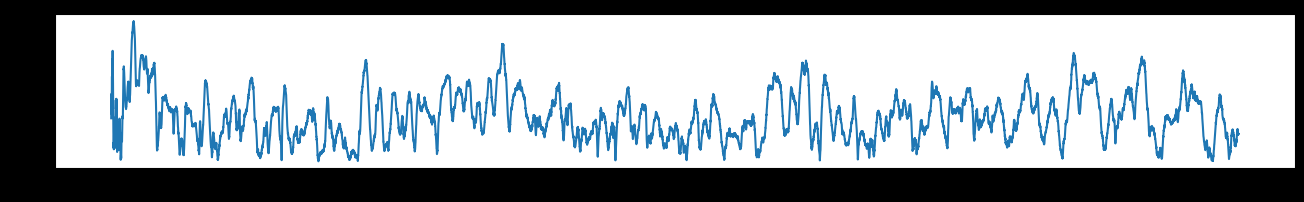

In [5]:
radar_file_path = os.path.join(folder_root, [file for file in files if file.endswith('.npy')][0])
ecg_file_path = os.path.join(folder_root, [file for file in files if file.endswith('.npz')][0])
raw_data_cub = np.load(radar_file_path)
plt.figure(figsize=(16, 2))
plt.style.use('default')
plt.plot(np.abs(raw_data_cub[:,0,0,0,0]))

('2025-02-17 15:47:35', '2025-02-17 15:48:35', 60.00182104110718)

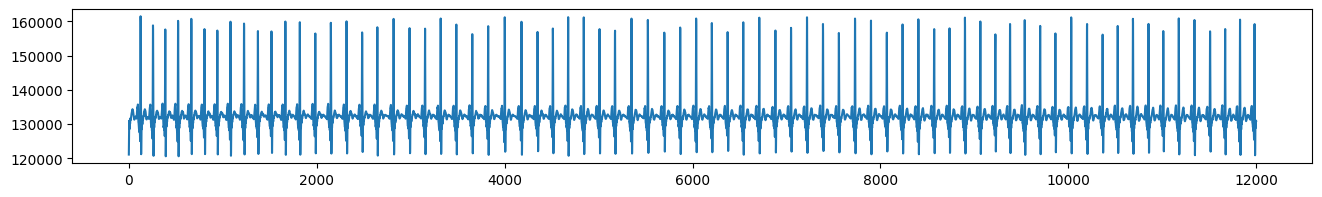

In [6]:
# example for ECG data processing from scratch
npzfile = np.load(ecg_file_path)
ECG_data = npzfile['ecg']
timestamp = npzfile['timestamp']
t = np.array(timestamp) - timestamp[0]
plt.figure(figsize=(16, 2))
plt.style.use('default')
plt.plot(ECG_data[:-1], label="ECG")
# time stamp to world time
start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(timestamp[0]))
end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(timestamp[-1]))
duration = timestamp[-1] - timestamp[0]
start_time, end_time, duration

### Alignment

In [7]:
dum_len = 100 # to avoid the edge effect
freq = 200
template_len = 4
# obtain the segment of template matching
start, length = int(40*freq)-dum_len, int(template_len*freq)+dum_len #start from 40s
start, length = int(20*freq)-dum_len, int(template_len*freq)+dum_len #start from 20s
data_cube = copy.deepcopy(raw_data_cub[start:start+length, ...])
print("Frame number:", data_cube.shape[0], "IQ:", data_cube.shape[1], "Tx,Rx:", data_cube.shape[2:4], "Sample/Chirp", data_cube.shape[4])
info = {"numFrames": data_cube.shape[0], "numRxAntennas": data_cube.shape[3], "freqSlope": 64.985e12, "waveLength": wavelength, "clip": data_cube.shape[0], "numLoopsPerFrame": 2}

Frame number: 900 IQ: 2 Tx,Rx: (3, 4) Sample/Chirp 256


### CFT search

In [8]:
dt = 1/freq
n = int(template_len*freq) # 4 sec
fs = 1/dt
t = np.linspace(0,n,n)*dt
a1, a2 = 0.85, 0.3 # a1 is the amplitude of the main peak
b1, b2 = 1.76, 2.1
c1, c2 = 0.1, 0.1
def loss(params, X, y):
    a1, a2, b1, b2, c1, c2 = params
    win_start, win_end = int((b1-0.4)*fs), int((b1+0.7)*fs) #1.2s window
    if win_start<0 or win_end>len(y):
        return 120000
    y_select = (y[win_start:win_end]) # Ground truth
    scale = np.max(y_select)
    # print('win_start:', win_start, 'win_end:', win_end)
    x1 = a1*np.exp(-((X-b1)**2)/(2*c1**2))
    x2 = a2*np.exp(-((X-b2)**2)/(2*c2**2))
    y_pred = x1 + x2
    x_select = y_pred[win_start:win_end]
    RMSE = np.sqrt(np.mean((norm(y_select) - norm(x_select)) ** 2))
    cor = np.corrcoef(y_select, x_select)[0,1]
    return (RMSE+0*(1-cor))*scale

def plot_template(a1, a2, b1, b2, c1, c2):
    fs = 200
    n = int(template_len*fs) # 4 sec
    dt = 1/fs
    t = np.linspace(0,n,n)*dt
    x1 = a1*np.exp(-((t-b1)**2)/(2*c1**2))
    x2 = a2*np.exp(-((t-b2)**2)/(2*c2**2))
    return x1+x2, int((b1-0.4)*fs), int((b2+0.7)*fs)

# Constraint on the related position of two prominent peaks
def cons1(params):
    return 0.3-params[3]+params[2] # the second vibration must within 0.5s after the first one
def cons2(params):
    return params[3]-params[2]-0.14 # the second vibration must be 0.14s after the first one
constraints = ({'type': 'ineq', 'fun': cons1}, {'type': 'ineq', 'fun': cons2})

def DTM_2(target_sig, params):
    costs = []
    a1s, a2s, b1s, b2s, c1s, c2s = [], [], [], [], [], []
    # the peaks will be the candidates for loss calculation
    scale = np.max(target_sig)
    peaks = find_peaks(target_sig, distance=100, prominence=0.3*scale, wlen=50)[0] 
    # print('peaks:', peaks, "scale", target_sig[peaks])  
    # peaks = peaks[(peaks>80) & (peaks<len(target_sig)-160)]
    if len(peaks)<=template_len-2:
        return [-1.],[-1.],[-1.],[-1.],[-1.],[-1.], 120011., [-1.] # ('Poor SNR, No enough peaks')
    # remove peaks that are too close to the start or the end
    template = np.zeros(len(target_sig))

    for peak in peaks:
        cost_dtm = 110000 # for the seletion for plot
        a1 = target_sig[peak]
        b1, b2 = dt*peak, dt*peak+0.3 
        _,_, _, _, c1, c2 = params
        x0 = [a1, a1*0.3, b1, b2, c1, c2]
        # print('x0:', x0, "peak", peak)
        bounds = Bounds([0.99,0.2,b1,0.01,0.02,0.02], [1,0.5,b1+0.1,template_len,0.11,0.11])

        res = minimize(loss, x0, method='SLSQP', bounds=bounds, constraints=constraints, args=(t, target_sig), tol=1e-8)
        costs.append(res.fun) 
        if res.fun<cost_dtm:
            a1, a2, b1, b2, c1, c2 = res.x
            a1s.append(a1), a2s.append(a2), b1s.append(b1), b2s.append(b2), c1s.append(c1), c2s.append(c2)
            cost_dtm = res.fun
        else:
            a1s.append(-1), a2s.append(-1), b1s.append(-1), b2s.append(-1), c1s.append(-1), c2s.append(-1)
    for i in range(len(a1s)):
        xt, win_start, win_end = plot_template(a1s[i], a2s[i], b1s[i], b2s[i], c1s[i], c2s[i])
        scale = target_sig[peaks[i]]
        template[win_start:win_end] += scale*(xt[win_start:win_end])
    RMSE = np.sqrt(np.mean((norm(target_sig) - norm(template)) ** 2))*np.max(target_sig)
    r2 = r2_score(norm(target_sig), norm(template))
    loss_final = (1-r2)*np.max(target_sig)
    loss_final = RMSE
    
    return np.array(a1s), np.array(a2s), np.array(b1s), np.array(b2s), np.array(c1s), np.array(c2s), loss_final/len(peaks), template 



In [9]:

import PyNomad

# This example of blackbox function is for a single process
# The blackbox output must be put in the EvalPoint passed as argument
def bb(x):
    dim = x.size()
    x0 = [x.get_coord(i) for i in range(dim)]
    s = calculation(data_cube, x0, antenna_loc, info)
    sig = np.angle(s)
    h = np.unwrap(sig)
    # mmwave_data = h
    sos = butter(6, [0.5,40], btype = 'bp', fs=freq, output='sos')
    h = sosfilt(sos, h)
    h = second_dev(h, 1/freq)
    mmwave_data = h[dum_len:]
    
    upper_env = np.abs(hilbert((mmwave_data)))
    target_sig = moving_window_average(upper_env, 21)
    _,_,_,_,_,_,f, _ = DTM_2(target_sig, params = [1,0.31,0.01,0.01, 0.11, 0.11])
    x.setBBO(str(f).encode("UTF-8"))
    return 1 # 1: success 0: failed evaluation

with open(os.path.join(folder_root, 'recommend.txt'), 'r') as f:
    recommend = eval(f.read())
x0 = recommend['x0']
print('x0:', x0)
x0 = [0,0.65,0]
lb = [-0.2, 0.6, -0.2]
ub = [0.2, 0.7, 0.2]

print("Initial point:", x0)
print("Lower bound:", lb)
print("Upper bound:", ub)

params = ["BB_OUTPUT_TYPE OBJ", "MAX_BB_EVAL 100", "DISPLAY_DEGREE 2", "DISPLAY_ALL_EVAL False", "DISPLAY_STATS BBE OBJ SOL"] 
params += ["HISTORY_FILE History.txt"]
params += ["GRANULARITY * 0.001"]
result = PyNomad.optimize(bb, x0, lb, ub, params)

fmt = ["{} = {}".format(n,v) for (n,v) in result.items()]
output = "\n".join(fmt)
print("\nNOMAD results \n" + output + " \n")


x0: [0.084, 0.621, 0.159]
Initial point: [0, 0.65, 0]
Lower bound: [-0.2, 0.6, -0.2]
Upper bound: [0.2, 0.7, 0.2]
All variables are granular. MAX_EVAL is set to 2700 to prevent algorithm from circling around best solution indefinitely
BBE OBJ SOL
1 120011       0       0.65    0    


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


3     47.128   0.03    0.655  -0.02 


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


11     46.278  -0.02    0.656  -0.05 


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


15     33.213   0.02    0.654  -0.06 


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clippi

43     29.551   0       0.653  -0.05 


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clippi

53     27.722  -0.02    0.648  -0.06 


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clippi

75     27.715  -0.02    0.648  -0.062


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside 

92     27.569  -0.018   0.649  -0.061


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize

A termination criterion is reached: Maximum number of blackbox evaluations (Eval Global) 100

Best feasible solution:     #13355 ( -0.018 0.649 -0.061 )	Evaluation OK	 f =  27.568580723723904669  	 h =   0                      (L2)

Best infeasible solution:   Undefined.

Blackbox evaluations:         100
Total model evaluations:      12540
Cache hits:                   19
Total number of evaluations:  119

NOMAD results 
x_best = [-0.018, 0.649, -0.061]
f_best = 27.568580723723905
h_best = 0.0
nb_evals = 100
nb_iters = 0
run_flag = 0
stop_reason = Maximum number of blackbox evaluations (Eval Global) 



/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [10]:
file_name = 'history.0.txt'
# structure: [x,y,z, loss_value]
df = pd.read_csv(file_name, skiprows=1, header=None, names=['col1', 'col2', 'col3', 'col4'], sep='\s+')
df = df.fillna(10000)
all_sols = df.values
# sort based on loss_value
all_sols = all_sols[np.argsort(all_sols[:,-1])]
best_points = all_sols[0,:-1]
best_points

array([-0.018,  0.649, -0.061])

In [11]:

x0 = [-0.019, 0.648, -0.056]
# x0 = [-0.0, 0.65, 0]
x0 = best_points
s = calculation(data_cube, x0, antenna_loc, info) 


In [12]:
def peak_error(ecg,radar, radar_prominence=0.05):
    ecg = norm(ecg)
    env_plt = moving_window_average(np.abs(hilbert((radar))), 21)
    scale = np.max(env_plt) 
    # peaks_radar = find_peaks(env_plt, distance=100, height=0.01*scale, prominence=radar_prominence*scale)[0]
    peaks_radar = find_peaks(env_plt, distance = 100, prominence=radar_prominence*scale, width = (1, 50))[0]
    scale = np.max(ecg)
    peaks_ecg = find_peaks(ecg, distance=100, height=0.005*scale, prominence=0.5*scale, wlen=50)[0]
    errors = []
    if len(peaks_radar)<1:
        return peaks_ecg, peaks_radar, 120000, env_plt
    for peak in peaks_ecg:
        temp_error = np.min(np.abs(peaks_radar - peak))
        errors.append(temp_error)

    return peaks_ecg, peaks_radar, np.sum(errors), env_plt

False
-6 106


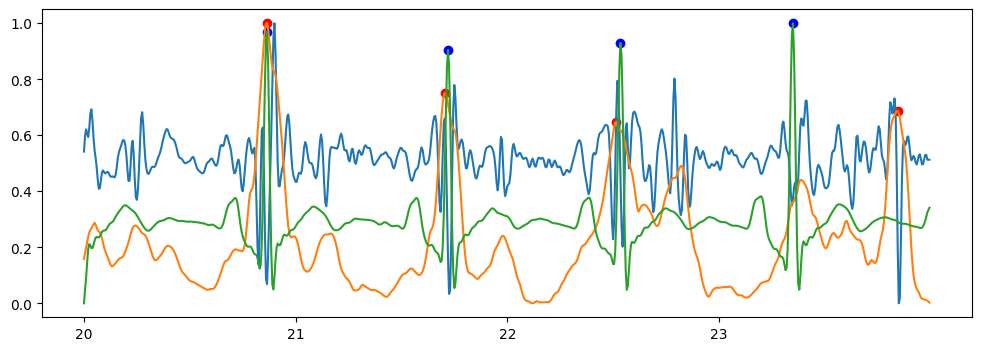

In [13]:
sig = np.angle(s)
h = np.unwrap(sig)
# mmwave_data = h
sos = butter(6, [0.5,40], btype = 'bp', fs=freq, output='sos')
h = second_dev(sosfilt(sos, h), 1/freq)
mmwave_data = h[dum_len:]
print(useless_data(mmwave_data))
dt = 1/freq # 5msper sample
t = np.arange(0, len(mmwave_data)*dt, dt)+(start+dum_len)*dt
offset_sec = -0.03
offset = int((offset_sec)*freq)
ECG_calibrated = ECG_data[start+dum_len-offset:start+length-offset]
peaks_ecg, peaks_radar, errors, env_plt = peak_error(ECG_calibrated, mmwave_data, radar_prominence=0.5)
print(offset, errors)
plt.figure(figsize=(12, 4))
plt.plot(t,norm((mmwave_data)))
plt.plot(t,norm(env_plt))
ECG_calibrated = smooth2nd(ECG_calibrated, 5)
scale = np.max(norm(ECG_calibrated))
plt.plot(t, norm(ECG_calibrated))
plt.xticks(np.arange(t[0], t[-1], 1))
plt.style.use('default')
plt.scatter(t[peaks_radar], norm(env_plt)[peaks_radar], c='r')
plt.scatter(t[peaks_ecg], norm(ECG_calibrated)[peaks_ecg], c='b')


loss: 27.568580723723905


/Users/zyy/anaconda3/envs/estHR/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


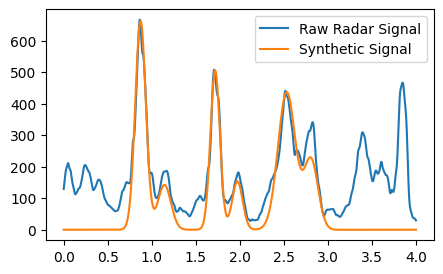

In [16]:
dt = 1/freq
n = int(template_len*freq) # 4 sec
t = np.linspace(0,n,n)*dt
target_sig = moving_window_average(np.abs(hilbert((mmwave_data))), 21)
a0 = [1,0.31,0.01,0.01, 0.11, 0.11]
a1s, a2s, b1s, b2s, c1s, c2s, loss_temp, template  = DTM_2(target_sig, a0)
print('loss:', loss_temp)   
plt.figure(figsize=(5,3))
plt.plot(t,(target_sig),label='Raw Radar Signal')
plt.plot(t,(template),label='Synthetic Signal')
plt.legend()